In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,  as_frame= False)
mnist.keys()

c:\Users\iamuj\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR Key describes the dataset
- Data key contains an array with one row per instance and one column   per feature
- target key contains an array with the labels


In [2]:
X, y = mnist["data"], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

- 70,000 images and each image has 784 features
- 784 cuz the images are 28x28 pixels and each pixel represents intensity from 0 (white) to 1 (black)

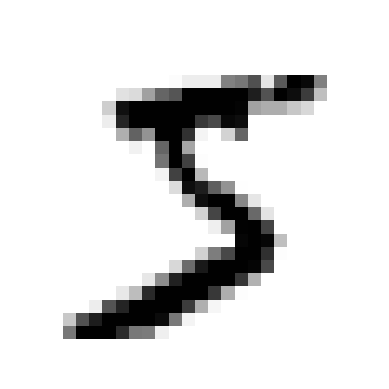

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Get an instances feature vector and reshape it to 28x28 to display the image
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
## Cast string labels to integers
import numpy as np
y = y.astype(np.uint8)

In [6]:
#### Splitting the dataset into train and test sets, 60000 training and 10k test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [7]:
### Trying to detect only one digit. The digit is 5 or not a 5.
y_train_5 = (y_train == 5)   ## True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sdg_clf = SGDClassifier()
sdg_clf.fit(X_train, y_train_5)

SGDClassifier()

In [9]:
sdg_clf.predict([some_digit]) ## Detecting the iamge of number 5 X[0]

array([ True])

Performance Measures

#### Cross Validation Implementatiom 

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sdg_clf)  ## At each iteration the code creates a clone of the classifier
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  ## Trains the clone on the training folds 
    y_pred = clone_clf.predict(X_test_folds)  ## Makes prediction on the test folds
    n_correct = sum(y_pred == y_test_folds)  ## Counts the number of correct predictions
    print(n_correct/len(y_pred))  ## Ratio of correct predictions
    

0.8802
0.88165
0.8596


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96505, 0.94185, 0.95805])

In [13]:
### Looking at a classifier that just classifies every single image in the "not a 5 class"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring="accuracy")
### Gives pretty high accuracy. THats why accuracy is not a preferred performance measure

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict  ## Cross_val_predict performs K fold cross validation but instead of returning the evaluation scores, it returns the predictions made on each test fold
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train_5, cv = 3)

In [19]:
## Getting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52444,  2135],
       [  856,  4565]], dtype=int64)

In [20]:
## Lets pretend we got perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

- Acuuracy of positive predictions = PRECISION
- Precision = TP/(TP+FP)
- Ratio of positive instances that are correctly detected by the classifier = RECALL
- Recall = TP/(TP + FN)

#### Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## 4565/(4566+2135)

0.6813432835820895

In [23]:
recall_score(y_train_5, y_train_pred)  ## 4565/(4565 + 856)

0.8420955543257701

when the classifier claims an image represents a 5, it is only correct 68% of the times and only detects 84% of the 5s

F1 Score is a Harmonic mean of precision and recall. HM gives much wt to low values. As a result, the classifier only get a high F1 score if both reacll and precision are high
- F1 = 2 x (precision x Recall) / (Precision + Recall)

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7532381816681791

iF YOU trained a classifier to detect videos that are safe for kids, we prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in the product.

On the other hand if we are training a classifier to detect the shoplifters on surveillance images, it is prob fine if the classifier has only 30% precision as long as it has 99% recall( sure, the security guards will get a few false alerts but almost all the shoplifters will get caught)

Unfortunately we cant have it both ways, increasing precision reduces recall and vice versa. This is called precision recall tradeoff